In [1]:
### connect to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import cv2

## Reading the datasets

In [3]:
### Folder path
PATH = r"/content/drive/MyDrive/Hull University/Understanding AI/labs/Emergency_Vehicles"

In [4]:
train_dir = PATH+'/train'
test_dir = PATH+'/test'
train_df = pd.read_csv(PATH+'/train.csv')
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [5]:
train_df.tail()

,image_names,emergency_or_not
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0
1645,860.jpg,1


In [6]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB


In [7]:
## Setting datatypes to string
train_df['emergency_or_not']=train_df['emergency_or_not'].astype(str)

## Displaying some images example

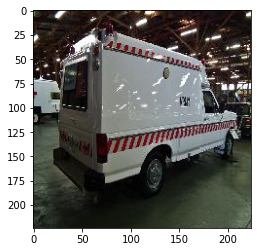

In [8]:
## Print an example of emergency vehicle
image = cv2.imread(train_dir+"/860.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # converting to RGB 
plt.imshow(image)

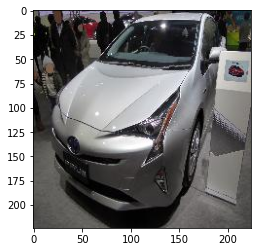

In [9]:
## Print an example of non emergency vehicle
image = cv2.imread(train_dir+"/1503.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # converting to RGB 
plt.imshow(image)

## Configuring the Image Data Generator


#### *Configuring image data generator and specifying the transformations*

In [10]:
# Keras image data generator is used for the generation
from keras.preprocessing.image import ImageDataGenerator 
batch_size = 50

In [11]:
# Applying the image transformations  
image_gen = ImageDataGenerator(  
    rotation_range=20,# specifies the rotation to be 20% 
    width_shift_range=0.1, # specifies the width shift of 10% 
    height_shift_range=0.1,# specifies the height shift of 10% 
    shear_range=0.20, # crops part of the image  
    zoom_range=0.20, # #zooms the image by 20% 
    fill_mode='nearest', # fills using the nearest pixel  
    horizontal_flip=True, # Secifies the horizontal flip  
    rescale=1/255 # scales the image  
)

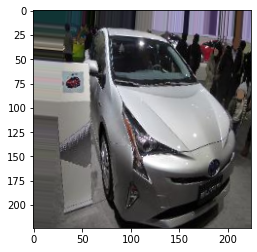

In [12]:
# showing the transformation 
plt.imshow(image_gen.random_transform(image))

#### *Setting up the generator for training and validation data*

- #### Using a train-test split ratio of 70-30.
- #### Get the dimensions of the training and validation generators.


In [13]:
train_generator = image_gen.flow_from_dataframe(dataframe = train_df[:1150],directory = train_dir,x_col ='image_names',
                                            y_col = 'emergency_or_not',class_mode = 'binary',batch_size = batch_size,
                                            target_size = (224,224))


validation_generator = image_gen.flow_from_dataframe(dataframe = train_df[1151:],directory = train_dir,x_col = 'image_names',
                                                y_col ='emergency_or_not',class_mode ='binary',batch_size = 50,
                                                target_size = (224,224))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


#### *Finding the dimensions of training and validation generators*

In [14]:
trainsample = next(train_generator)
print("Dimensions of training sample",trainsample[0].shape)
valsample = next(validation_generator)
print("Dimensions of validation sample",valsample[0].shape)

Dimensions of training sample (50, 224, 224, 3)
Dimensions of validation sample (50, 224, 224, 3)


#### *Finding the number of samples in each generator*

In [15]:
num_train_samples = train_generator.samples
num_val_samples = validation_generator.samples

print("Number of training samples", num_train_samples)
print("Number of validation samples", num_val_samples)

Number of training samples 1150
Number of validation samples 495


##  Building a CNN


In [16]:

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization 
from keras.regularizers import l1, l2

#from tensorflow.keras import datasets, layers, models, callbacks
import pickle

#### *Constructor stage*

In [ ]:
model = Sequential() #instantiate the sequential model

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same")) # add convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))  #add pooling layer
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same")) #add another convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))  #add pooling layer
model.add(Flatten()) # flatten the convolutional feature map for use in the fully connected layers
model.add(Dense(50,activation = 'relu')) # add a dense layer with an output dimension of 50 and a relu activation function
model.add(Dense(units = 1, activation='sigmoid')) # add the output layer with sigmond as the activation function

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy') # compile the model

In [ ]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 50)                5

In [ ]:
history = model.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 469s 20s/step - loss: 1.2003 - accuracy: 0.4983 - val_loss: 0.6861 - val_accuracy: 0.7475
Epoch 2/50
23/23 [==============================] - 93s 4s/step - loss: 0.6472 - accuracy: 0.6904 - val_loss: 0.5480 - val_accuracy: 0.7333
Epoch 3/50
23/23 [==============================] - 92s 4s/step - loss: 0.5790 - accuracy: 0.7035 - val_loss: 0.5005 - val_accuracy: 0.7556
Epoch 4/50
23/23 [==============================] - 93s 4s/step - loss: 0.5297 - accuracy: 0.7496 - val_loss: 0.4794 - val_accuracy: 0.7838
Epoch 5/50
23/23 [==============================] - 90s 4s/step - loss: 0.5449 - accuracy: 0.7252 - val_loss: 0.5158 - val_accuracy: 0.7758
Epoch 6/50
23/23 [==============================] - 90s 4s/step - loss: 0.5288 - accuracy: 0.7539 - val_loss: 0.4765 - val_accuracy: 0.7717
Epoch 7/50
23/23 [==============================] - 92s 4s/step - loss: 0.5029 - accuracy: 0.7617 - val_loss: 0.4718 - val_accuracy: 0.7758
Epoch 8/50
23/23 [

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
pd.DataFrame(history.history).tail()

,loss,accuracy,val_loss,val_accuracy
45,0.306978,0.875652,0.357942,0.836364
46,0.317478,0.865217,0.317382,0.866667
47,0.317717,0.866087,0.357010,0.844444
48,0.307093,0.866087,0.350737,0.844444
49,0.313342,0.864348,0.355780,0.850505


#### *Plotting the losses and accuracy*

In [17]:
def model_history_plot(history, title, filename):
  """Function takes in the model history to make plots of the loss and accuracy metrics"""
  figure = plt.figure(figsize = (10,4))
  ax = plt.subplot(121)

  ax.plot(history.history['loss'], 'r', label = 'train')
  ax.plot(history.history['val_loss'],'g',label = 'val')

  plt.legend()
  plt.grid(axis = 'y')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  ax2 = plt.subplot(122)
  ax2.plot(history.history['accuracy'], 'b', label="train")
  ax2.plot(history.history['val_accuracy'], 'g', label="val")
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.grid(axis='y')
  plt.suptitle(title+'\n', fontsize=12)
  plt.savefig(os.path.join(PATH, filename))

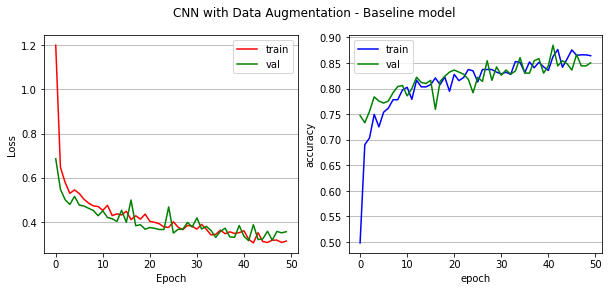

In [ ]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation - Baseline model'
filename='baseline_model_loss_acurr.png'
model_history_plot(history, title, filename)

## Handling overfitting and underfitting



### Building CNN with Early Stopping

In [20]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_es.h5', monitor = 'val_loss',verbose=0, save_best_only=True)

In [21]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model2.add(MaxPooling2D(pool_size=(2,2))) 
model2.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model2.add(MaxPooling2D(pool_size=(2,2)))  #add pooling layer
model2.add(Flatten())
model2.add(Dense(50,activation = 'relu')) 
model2.add(Dense(units = 1, activation='sigmoid'))

callbacks = [early_stopping_callback, model_checkpoint_callback] ##adding early stopping as regularisation parameter

model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [22]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 50)                5

In [23]:
history2 = model2.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50, callbacks = callbacks)



Epoch 1/50
23/23 [==============================] - 474s 21s/step - loss: 1.0859 - accuracy: 0.5574 - val_loss: 0.6383 - val_accuracy: 0.6242
Epoch 2/50
23/23 [==============================] - 98s 4s/step - loss: 0.6445 - accuracy: 0.6652 - val_loss: 0.5436 - val_accuracy: 0.7455
Epoch 3/50
23/23 [==============================] - 92s 4s/step - loss: 0.5670 - accuracy: 0.7313 - val_loss: 0.5130 - val_accuracy: 0.7657
Epoch 4/50
23/23 [==============================] - 93s 4s/step - loss: 0.5434 - accuracy: 0.7383 - val_loss: 0.4792 - val_accuracy: 0.7697
Epoch 5/50
23/23 [==============================] - 95s 4s/step - loss: 0.5236 - accuracy: 0.7478 - val_loss: 0.4833 - val_accuracy: 0.7879
Epoch 6/50
23/23 [==============================] - 94s 4s/step - loss: 0.4927 - accuracy: 0.7809 - val_loss: 0.4423 - val_accuracy: 0.8020
Epoch 7/50
23/23 [==============================] - 97s 4s/step - loss: 0.4854 - accuracy: 0.7626 - val_loss: 0.4280 - val_accuracy: 0.7919
Epoch 8/50
23/23 [

In [24]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
pd.DataFrame(history2.history).tail()

,loss,accuracy,val_loss,val_accuracy
31,0.351134,0.834783,0.346978,0.842424
32,0.363130,0.841739,0.375621,0.838384
33,0.327087,0.852174,0.353793,0.862626
34,0.329238,0.857391,0.436387,0.800000
35,0.312405,0.862609,0.348687,0.856566


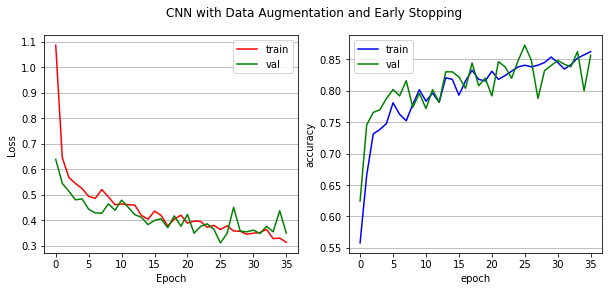

In [26]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation and Early Stopping'
filename='CNN_data_augmentation_early_stopping.png'
model_history_plot(history2, title, filename)

### CNN with Dropouts

#### Dropout with 0.2

In [27]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model3.add(MaxPooling2D(pool_size=(2,2))) 
model3.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model3.add(Flatten())
model3.add(Dense(50,activation = 'relu')) 
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, activation='sigmoid'))

model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [28]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 flatten_1 (Flatten)         (None, 401408)            0         
                                                                 
 dense_2 (Dense)             (None, 50)                20070450  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                      

In [29]:
history3 = model3.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 101s 4s/step - loss: 1.4949 - accuracy: 0.5417 - val_loss: 0.6488 - val_accuracy: 0.6525
Epoch 2/50
23/23 [==============================] - 95s 4s/step - loss: 0.6287 - accuracy: 0.6861 - val_loss: 0.5574 - val_accuracy: 0.7232
Epoch 3/50
23/23 [==============================] - 94s 4s/step - loss: 0.5849 - accuracy: 0.7061 - val_loss: 0.5342 - val_accuracy: 0.7556
Epoch 4/50
23/23 [==============================] - 99s 4s/step - loss: 0.5806 - accuracy: 0.7061 - val_loss: 0.5347 - val_accuracy: 0.7556
Epoch 5/50
23/23 [==============================] - 95s 4s/step - loss: 0.5614 - accuracy: 0.7348 - val_loss: 0.5134 - val_accuracy: 0.7636
Epoch 6/50
23/23 [==============================] - 95s 4s/step - loss: 0.5294 - accuracy: 0.7443 - val_loss: 0.4813 - val_accuracy: 0.7717
Epoch 7/50
23/23 [==============================] - 99s 4s/step - loss: 0.5098 - accuracy: 0.7522 - val_loss: 0.4849 - val_accuracy: 0.7879
Epoch 8/50
23/23 [=

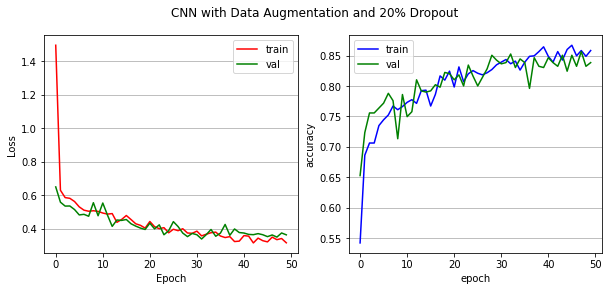

In [30]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation and 20% Dropout'
filename='CNN_data_augmentation_dropout_0_2.png'
model_history_plot(history3, title, filename)

In [31]:
pd.DataFrame(history3.history).tail()

,loss,accuracy,val_loss,val_accuracy
45,0.320423,0.866957,0.351740,0.850505
46,0.348678,0.849565,0.361636,0.832323
47,0.333554,0.858261,0.349059,0.856566
48,0.340526,0.848696,0.373614,0.832323
49,0.314839,0.858261,0.362447,0.838384


#### Dropout = 0.5 : 50% dropout

In [32]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model4.add(MaxPooling2D(pool_size=(2,2))) 
model4.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model4.add(Flatten())
model4.add(Dense(50,activation = 'relu')) 
model4.add(Dropout(0.5)) 
model4.add(Dense(units = 1, activation='sigmoid'))

model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

history4 = model4.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 98s 4s/step - loss: 2.7660 - accuracy: 0.5722 - val_loss: 0.6778 - val_accuracy: 0.6990
Epoch 2/50
23/23 [==============================] - 99s 4s/step - loss: 0.6588 - accuracy: 0.6391 - val_loss: 0.5917 - val_accuracy: 0.7010
Epoch 3/50
23/23 [==============================] - 94s 4s/step - loss: 0.6052 - accuracy: 0.6965 - val_loss: 0.5446 - val_accuracy: 0.7273
Epoch 4/50
23/23 [==============================] - 94s 4s/step - loss: 0.5808 - accuracy: 0.7191 - val_loss: 0.5186 - val_accuracy: 0.7636
Epoch 5/50
23/23 [==============================] - 97s 4s/step - loss: 0.5552 - accuracy: 0.7374 - val_loss: 0.4983 - val_accuracy: 0.7798
Epoch 6/50
23/23 [==============================] - 99s 4s/step - loss: 0.5466 - accuracy: 0.7330 - val_loss: 0.5163 - val_accuracy: 0.7697
Epoch 7/50
23/23 [==============================] - 95s 4s/step - loss: 0.5428 - accuracy: 0.7426 - val_loss: 0.5339 - val_accuracy: 0.7455
Epoch 8/50
23/23 [==

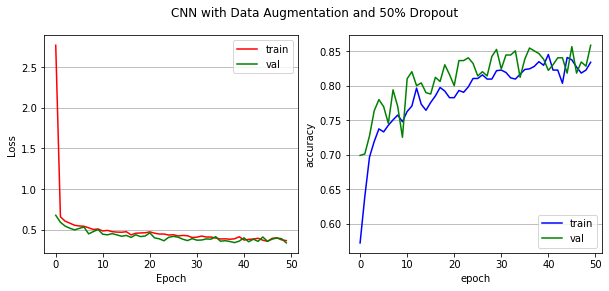

In [33]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation and 50% Dropout'
filename='CNN_data_augmentation_dropout_0_5.png'
model_history_plot(history4, title, filename)

In [34]:
pd.DataFrame(history4.history)['val_loss'].mean()

0.4218977952003479

In [35]:
pd.DataFrame(history4.history)['loss'].mean()

0.4935574918985367

In [36]:
pd.DataFrame(history4.history)['accuracy'].mean()

0.7886086976528168

In [37]:
pd.DataFrame(history4.history)['val_accuracy'].mean()

0.8118383824825287

In [38]:
pd.DataFrame(history4.history).tail()

,loss,accuracy,val_loss,val_accuracy
45,0.357386,0.837391,0.358244,0.856566
46,0.394754,0.826957,0.384820,0.818182
47,0.400891,0.818261,0.398814,0.834343
48,0.375363,0.822609,0.389867,0.828283
49,0.366727,0.833913,0.338223,0.858586


## CNN with Regularization : L1 and L2

#### Lasso (L1) regularization

In [18]:
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same",kernel_regularizer=l1(0.01)))
model5.add(MaxPooling2D(pool_size=(2,2))) 
model5.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model5.add(Flatten())
model5.add(Dense(50,activation = 'relu')) 
model5.add(Dense(units = 1, activation='sigmoid'))

model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

history5 = model5.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 449s 19s/step - loss: 1.8348 - accuracy: 0.5635 - val_loss: 1.1726 - val_accuracy: 0.6828
Epoch 2/50
23/23 [==============================] - 98s 4s/step - loss: 1.1167 - accuracy: 0.6826 - val_loss: 1.0299 - val_accuracy: 0.7192
Epoch 3/50
23/23 [==============================] - 95s 4s/step - loss: 1.0301 - accuracy: 0.7148 - val_loss: 0.9762 - val_accuracy: 0.7515
Epoch 4/50
23/23 [==============================] - 98s 4s/step - loss: 0.9834 - accuracy: 0.7270 - val_loss: 0.9664 - val_accuracy: 0.7232
Epoch 5/50
23/23 [==============================] - 100s 4s/step - loss: 0.9365 - accuracy: 0.7348 - val_loss: 0.8874 - val_accuracy: 0.7859
Epoch 6/50
23/23 [==============================] - 97s 4s/step - loss: 0.8842 - accuracy: 0.7687 - val_loss: 0.8170 - val_accuracy: 0.7798
Epoch 7/50
23/23 [==============================] - 95s 4s/step - loss: 0.8615 - accuracy: 0.7722 - val_loss: 0.8169 - val_accuracy: 0.7879
Epoch 8/50
23/23 

In [19]:
pd.DataFrame(history5.history).tail()

,loss,accuracy,val_loss,val_accuracy
45,0.471743,0.880870,0.520253,0.848485
46,0.443228,0.885217,0.581376,0.846465
47,0.493594,0.878261,0.582023,0.826263
48,0.483124,0.871304,0.541609,0.846465
49,0.440906,0.897391,0.515454,0.858586


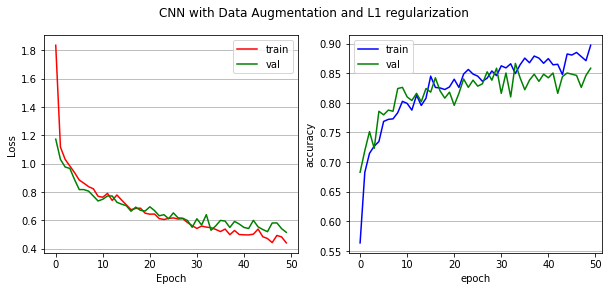

In [20]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation and L1 regularization'
filename='CNN_data_aug_L1_regularization.png'
model_history_plot(history5, title, filename)

#### L2 (Ridge Regression) regularization

In [21]:
model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(224,224,3), padding="same", kernel_regularizer=l2(0.01)))
model6.add(MaxPooling2D(pool_size=(2,2))) 
model6.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"))
model6.add(Flatten())
model6.add(Dense(50,activation = 'relu')) 
model6.add(Dense(units = 1, activation='sigmoid'))

model6.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

history6 = model6.fit(train_generator, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = validation_generator,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 101s 4s/step - loss: 2.7582 - accuracy: 0.5617 - val_loss: 0.7396 - val_accuracy: 0.6121
Epoch 2/50
23/23 [==============================] - 98s 4s/step - loss: 0.7257 - accuracy: 0.5800 - val_loss: 0.7211 - val_accuracy: 0.6081
Epoch 3/50
23/23 [==============================] - 96s 4s/step - loss: 0.7184 - accuracy: 0.5957 - val_loss: 0.6886 - val_accuracy: 0.6808
Epoch 4/50
23/23 [==============================] - 99s 4s/step - loss: 0.6992 - accuracy: 0.6548 - val_loss: 0.6586 - val_accuracy: 0.6646
Epoch 5/50
23/23 [==============================] - 98s 4s/step - loss: 0.6758 - accuracy: 0.6574 - val_loss: 0.6406 - val_accuracy: 0.6990
Epoch 6/50
23/23 [==============================] - 97s 4s/step - loss: 0.6549 - accuracy: 0.6791 - val_loss: 0.5990 - val_accuracy: 0.7455
Epoch 7/50
23/23 [==============================] - 99s 4s/step - loss: 0.6215 - accuracy: 0.7113 - val_loss: 0.7008 - val_accuracy: 0.6485
Epoch 8/50
23/23 [=

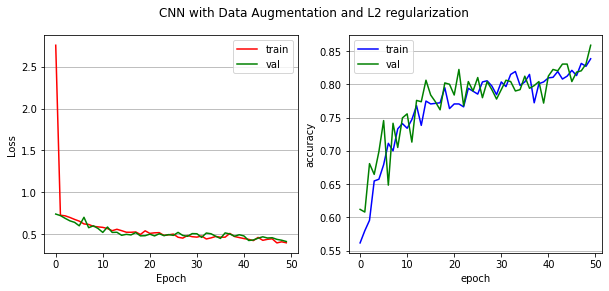

In [22]:
#### Plot model loss and accurarcy to check for overfitting  
title= 'CNN with Data Augmentation and L2 regularization'
filename='CNN_data_aug_L2_regularization.png'
model_history_plot(history6, title, filename)

In [23]:
pd.DataFrame(history6.history).tail()

,loss,accuracy,val_loss,val_accuracy
45,0.437538,0.820870,0.453135,0.804040
46,0.443643,0.813043,0.456670,0.818182
47,0.394482,0.831304,0.436938,0.820202
48,0.407756,0.826957,0.426766,0.830303
49,0.396073,0.838261,0.411187,0.858586
